In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ezgatr.interfaces import point, rotation
from ezgatr.nets.mv_only_gatr import MVOnlyGATrModel, MVOnlyGATrConfig
from tqdm import tqdm
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.transforms import random_rotation, matrix_to_quaternion
from pytorch3d.loss import chamfer_distance

In [2]:
def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, y, z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [3]:
# Load the dolphin mesh.
device = "cuda:0"
trg_obj = "dolphin.obj"

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

/home/catcat/projects/img2pc/.venv/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [ ]:
model = MVOnlyGATrModel(
    MVOnlyGATrConfig(
        num_layers=2,
        size_channels_in=2,
        size_channels_hidden=16,
        norm_channelwise_rescale=True,
        attn_is_causal=False,
    )
)
model = model.to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-5,
)

  0%|          | 0/10001 [00:00<?, ?it/s]

total_loss = 0.534730:   0%|          | 0/10001 [00:00<?, ?it/s]

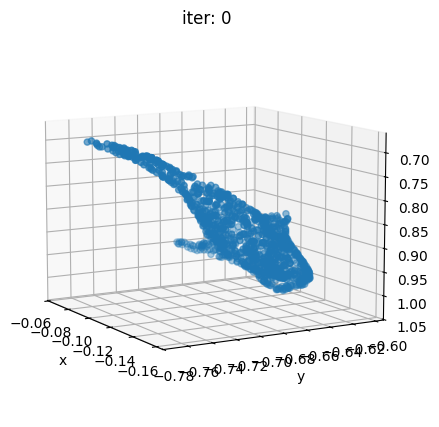

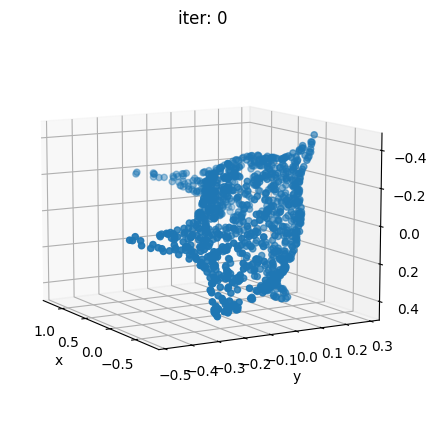

total_loss = 0.078842:  20%|█▉        | 1967/10001 [02:54<11:37, 11.52it/s] 

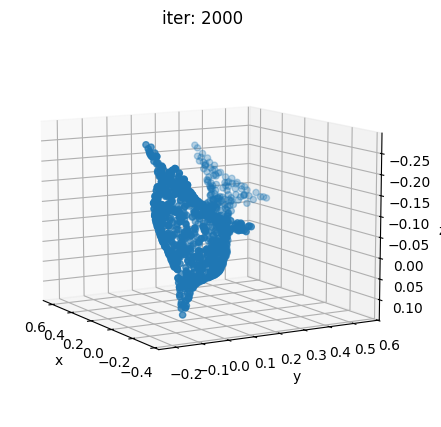

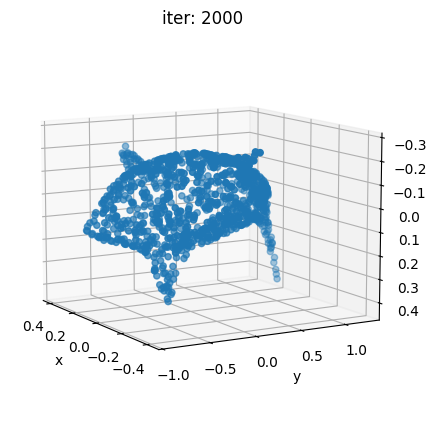

total_loss = 0.000177:  40%|███▉      | 3954/10001 [05:51<10:44,  9.38it/s]  

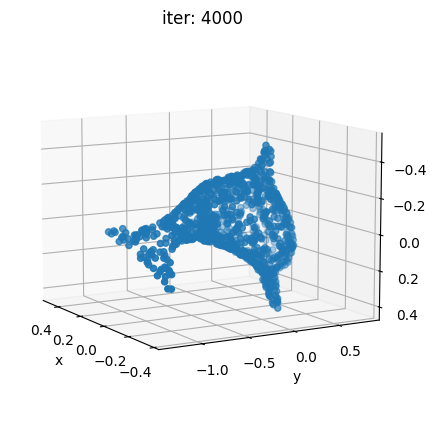

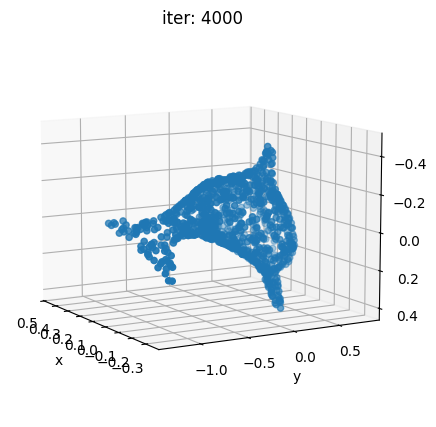

total_loss = 0.000158:  59%|█████▉    | 5948/10001 [08:52<05:59, 11.28it/s]

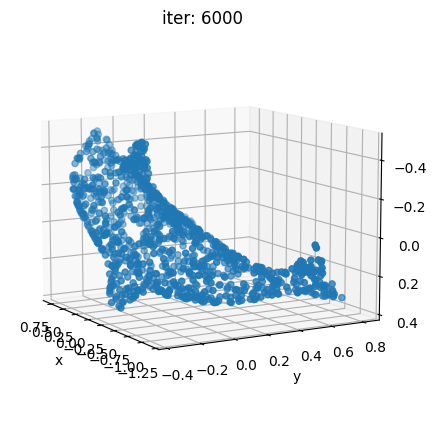

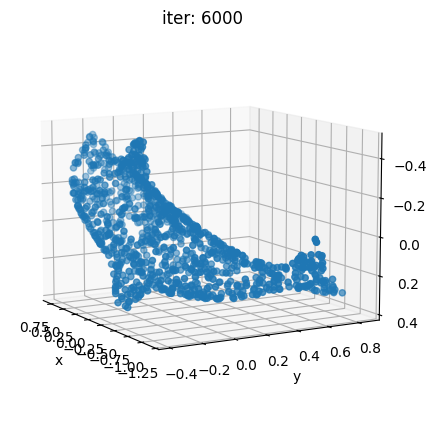

total_loss = 0.000031:  80%|███████▉  | 7978/10001 [11:49<04:26,  7.60it/s]  

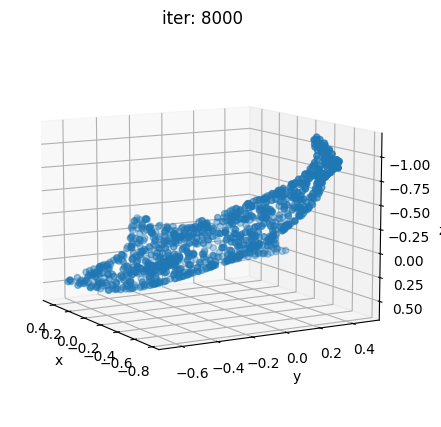

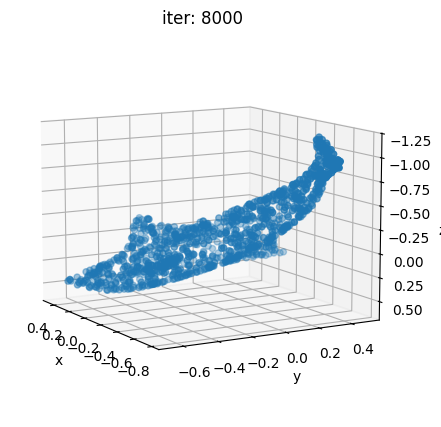

total_loss = 0.000048: 100%|█████████▉| 9999/10001 [14:46<00:00, 10.24it/s]

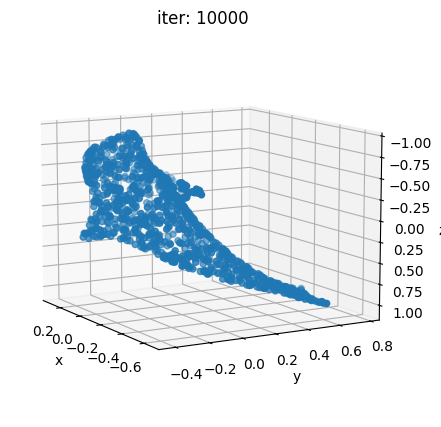

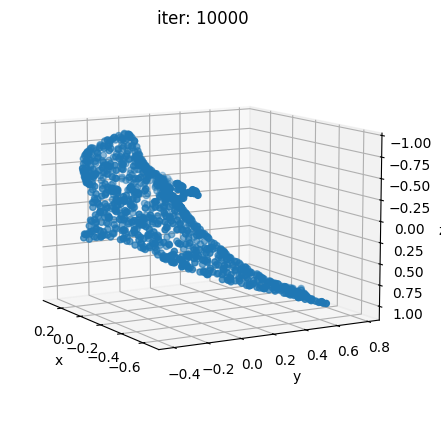

total_loss = 0.000048: 100%|██████████| 10001/10001 [14:47<00:00, 11.27it/s]


In [5]:
%matplotlib inline

criterion = nn.MSELoss()
losses = []

loop = tqdm(range(10001))
for i in loop:
    r = random_rotation(dtype=torch.float, device=device)
    x = sample_points_from_meshes(trg_mesh, 1024)
    y = torch.einsum("bni, ji -> bnj", x.detach(), r) # * 2 + torch.ones_like(x) * 0.1
    # y = sample_points_from_meshes(trg_mesh, 1024)

    x = point.encode_pga(x).unsqueeze(-2)
    r = (
        rotation.encode_pga(matrix_to_quaternion(r)[..., [1, 2, 3, 0]])
        .reshape(1, 1, 1, 16)
        .repeat((1, 1024, 1, 1))
    )
    # p, _ = model(torch.cat([x, r], dim=-2), scalars=None)
    p = model(torch.cat([x, r], dim=-2))
    p = point.decode_pga(p).squeeze(-2)

    loss = criterion(p, y)
    losses.append(float(loss.detach().cpu()))

    loop.set_description('total_loss = %.6f' % loss)
    if i % 2000 == 0:
        plot_pointcloud(p, title="iter: %d" % i)
        plot_pointcloud(y, title="iter: %d" % i)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()